In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('resnet-34-to-classify-fishes')
jovian.set_colab_id('1tjh-a-jnlPB1K2924bDUkGAPURpd6O5j')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="course-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anityagangurde01/course-project


'https://jovian.ai/anityagangurde01/course-project'

# course-project

I have selected the Fish Dataset from Kaggle as the course-project dataset. It is multiclass image classification dataset with 9 classes. 
Lets start by downloading the dataset from Kaggle.

In [ ]:
#some using downloads before starting
!pip install opendatasets --upgrade --quiet
!pip install albumentations==0.4.6

#**Importing**

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision
import tarfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

We will start by downloading the Fish Dataset from Kaggle by using *opendatasets*.

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/crowww/a-large-scale-fish-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./a-large-scale-fish-dataset" (use force=True to force download)


In [ ]:
root_dir = '/content/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
path = Path(root_dir)
path_images = list(path.glob('**/*.png'))

#Data Cleaning

If you check out the folder containing our data, there are two folders in every class folder. One is the actual image folder and the other is the *GT* image folder with *Ground Truth* images of the original images. 
We will just ignore the GT folder for every class to make it easier.

In [ ]:
images_paths = [str(path_image) for path_image in path_images if 'GT' not in str(path_image)]
print(f'Number of training images :{len(images_paths)}')

labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]
print(f'Number of labels :{len(labels)}')

Number of training images :9000
Number of labels :9000


In [ ]:
classes = list(set(labels))
labels_str_to_int = {label : i for i,label in enumerate(classes)}
labels_int = [labels_str_to_int[str_label] for str_label in labels]

Some information about the classes:

In [ ]:
print("No. of classes:", len(classes))
print("Various Classes:", classes)

No. of classes: 9
Various Classes: ['Trout', 'Sea Bass', 'Black Sea Sprat', 'Gilt-Head Bream', 'Striped Red Mullet', 'Red Mullet', 'Shrimp', 'Red Sea Bream', 'Hourse Mackerel']


Lets have a look at some images in the dataset:

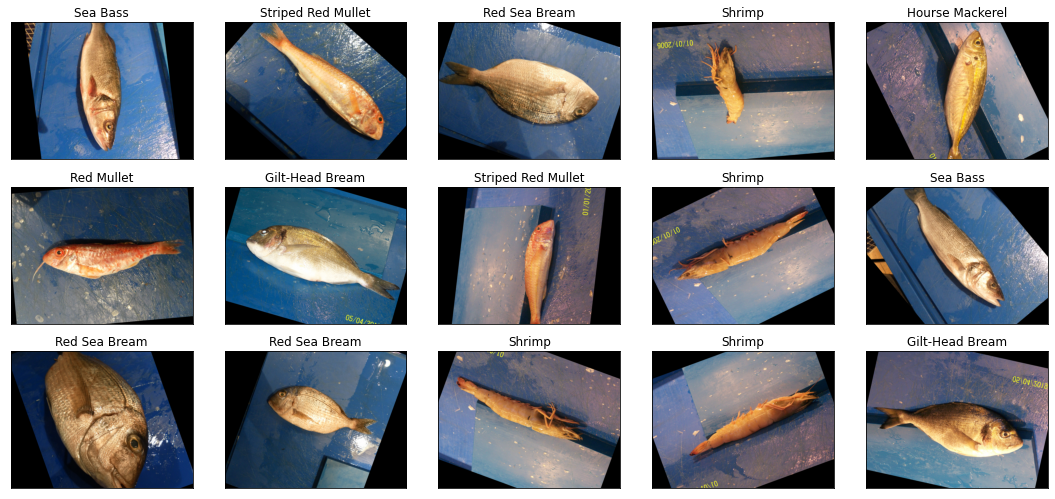

In [ ]:
#Creating a dummy dataset from our original data called image_df:
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_images))

filepaths = pd.Series(path_images, name='Filepath').astype(str)
Labels = pd.Series(Labels, name='Label')

image_df = pd.concat([filepaths, Labels], axis=1)
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]
image_df = image_df.sample(frac=1).reset_index(drop = True)#shuffling the images

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

Splitting the data into train, test, and validation datasets.

In [ ]:
#Splitting test from the whole dataset
data, test_data, labels, test_labels = train_test_split(images_paths, labels_int, test_size=0.15, shuffle=True)
#Splitting train and validation
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)

A class to create our Fish Dataset...

In [ ]:
class FishDataset(torch.utils.data.Dataset):
    def __init__(self, images: list, labels: list, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self, ):
        return len(self.labels)

    def __getitem__(self, index):
        input_image = self.images[index]
        label = self.labels[index]
        image = np.array(Image.open(input_image).convert("RGB"))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        return image, label

Transforms: (using a library called albumentations)

In [ ]:
train_transforms = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=160, width=240),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [ ]:
jovian.commit(project='course-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anityagangurde01/course-project


'https://jovian.ai/anityagangurde01/course-project'

Creating our datasets:

In [ ]:
train_ds = FishDataset(images=train_data,labels=train_labels,transform=train_transforms)

val_ds = FishDataset(images=val_data,labels=val_labels,transform=val_transforms)

test_ds = FishDataset(images=test_data,labels=test_labels,transform=val_transforms)

    

Converting them into data loaders:

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)   

val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)

test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)

#Model Building

Image classification base class:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {}, val_loss: {}, val_acc: {}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


Using ResNet34 as a pretrained model:

In [ ]:
from torchvision import models

class FishModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.network = models.resnet34(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)



Functions to check GPU usability and putting the data and the model on the GPU:

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


Some more helpful functions:

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

Putting the data on the GPU:

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

Instantiating the model object and putting it on the GPU:

In [ ]:
model = FishModel(len(classes))
to_device(model, device);

#Model Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.14636458456516266, 'val_loss': 2.3822555541992188}]

Defining some hyperparameters beforehand:

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Training the model:

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00596, train_loss: 0.4052981436252594, val_loss: 166.8714141845703, val_acc: 0.11251042038202286



Epoch [1],last_lr: 0.00994, train_loss: 0.35139745473861694, val_loss: 2.6475167274475098, val_acc: 0.5150208473205566



Epoch [2],last_lr: 0.00812, train_loss: 0.15961943566799164, val_loss: 1.8906810283660889, val_acc: 0.660239577293396



Epoch [3],last_lr: 0.00463, train_loss: 0.0492803156375885, val_loss: 0.6517562866210938, val_acc: 0.8197813034057617



Epoch [4],last_lr: 0.00133, train_loss: 0.010840636678040028, val_loss: 0.004110577516257763, val_acc: 0.9986979365348816



Epoch [5],last_lr: 0.00000, train_loss: 0.0037905622739344835, val_loss: 0.0036439108662307262, val_acc: 0.9986979365348816
CPU times: user 49.7 s, sys: 39.3 s, total: 1min 28s
Wall time: 7min 1s


In [ ]:
jovian.commit(project='course-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anityagangurde01/course-project


'https://jovian.ai/anityagangurde01/course-project'

#Model Testing

In [ ]:
def eval_accuracy(loader):  
    model.eval()
    corrects = 0
    total = 0
    for images, labels in loader:
        images, labels = to_device(images, device), to_device(labels, device)
        predictions = model(images)
        predict = to_device(torch.max(predictions.data, 1)[1], device)
        total += len(labels)
        corrects += (predict == labels).sum()
    accuracy = 100 * corrects / float(total)
    return accuracy

In [ ]:
test_acc = eval_accuracy(test_loader)
print(f' Accuracy on test images: {test_acc}')

 Accuracy on test images: 99.70370483398438


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def predict_image(image):
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

Label: Black Sea Sprat , Predicted: Black Sea Sprat


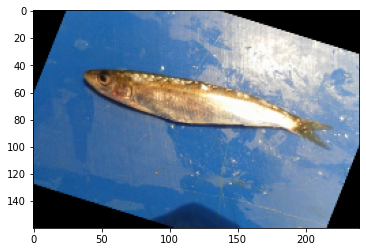

In [ ]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))


Label: Red Sea Bream , Predicted: Red Sea Bream


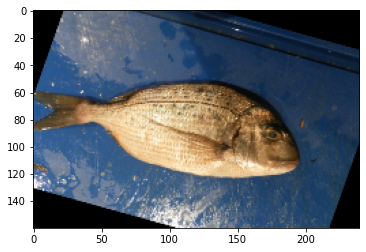

In [ ]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))

Label: Sea Bass , Predicted: Sea Bass


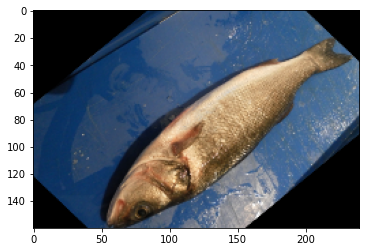

In [ ]:
img, label = test_ds[800]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img))

Some graphs to make it more clear:

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

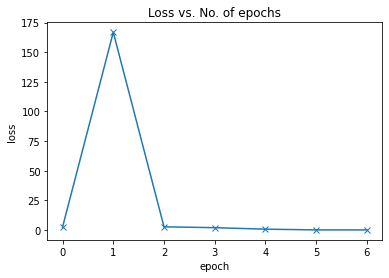

In [ ]:
plot_losses(history)

We can see from the above figure that the loss first increases at around first epoch and then steeply decreases as we keep on training.

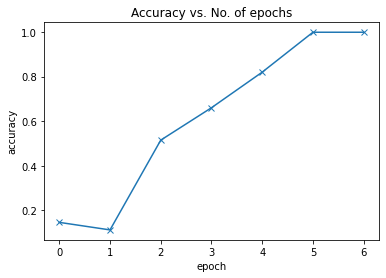

In [ ]:
plot_accuracies(history)

As we train the model, our accuracy keeps on increasing and then flattens very close to 100%.

In [ ]:
jovian.commit(project_name='course-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/anityagangurde01/course-project


'https://jovian.ai/anityagangurde01/course-project'

#Saving the Model

In [ ]:
torch.save(model.state_dict(), 'fish-model-feedforward.pth')

In [ ]:
test_dl = DeviceDataLoader(test_loader, device)
result = evaluate(model, test_dl)
result

{'val_acc': 0.9965705871582031, 'val_loss': 0.009597193449735641}

Logging the metrics of the test result:

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


#Conclusion: 


In [ ]:
print("We used a RESNET34 model to predict and classify fish images and achieved a test accuracy of {:.2f}%.".format(test_acc))
print("We can try to further improve this by changing the batch size, using a different optimization algorithm, increasing the number of epochs and/or using different pretrained model such as RESNET50.")


We used a RESNET34 model to predict and classify fish images and achieved a test accuracy of 99.70%.
We can try to further improve this by changing the batch size, using a different optimization algorithm, increasing the number of epochs and/or using different pretrained model such as RESNET50.


In [ ]:
jovian.commit(project_name='course-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/anityagangurde01/course-project


'https://jovian.ai/anityagangurde01/course-project'